# Scraping Indeed Job listings for the term "Data Scientist"

This little demo will scrape job listings and company information from Indeed.com

This code has been taken from a post on the NYC Data Science Academy website titled [Project 3: Web Scraping Company Data from Indeed.com and Dice.com](http://blog.nycdatascience.com/student-works/project-3-web-scraping-company-data-from-indeed-com-and-dice-com/) by [Sung Pil Moon](http://blog.nycdatascience.com/author/monspo1/).

I have modified the code to work properly with Indeed.com's new HTML structure.

## Scraping the listings

First we need to get the job listings, if you click the link below you can see the page we are going to scrape:
https://www.indeed.com/jobs?q=data+scientist&jt=fulltime&sort=date

There are 21,209 listings! This is way too many to copy and past by hand, lets automate it!

In [25]:
# 
from bs4 import BeautifulSoup as Soup
import requests
import pandas as pd

%matplotlib inline
# indeed.com url
base_url = 'http://www.indeed.com/jobs?q=data+scientist&jt=fulltime&sort='
sort_by = 'date'          # sort by data
start_from = '&start='    # start page number
home_url = "http://www.indeed.com"





In [2]:
# Create a list to contain all the job postings
job_listings = []

for page in range(1,101): # page from 1 to 100 (last page we can scrape is 100)
    if page % 10 == 0:
        print("Scraping page {}".format(page))
    page = (page-1) * 10  
    url = "%s%s%s%d" % (base_url, sort_by, start_from, page) # get full url
    target = Soup(requests.get(url).text, "lxml") 

    targetElements = target.findAll('div', attrs={'class' : 'result'}) # we're interested in each row (= each job)
    
    # trying to get each specific job information (such as company name, job title, urls, ...)
    for elem in targetElements:
        
        try:
            comp_name = elem.find('span', "company").text.strip()
            job_title = elem.find('a', attrs={'class':'turnstileLink'}).attrs['title']
            job_addr = elem.find('span',"location").text
            job_link = "%s%s" % (home_url,elem.find('a').get('href'))
            job_summary = elem.find('span',"summary").text.strip()

            if elem.find('span', "company").find("a"):

                company_link = elem.find('span', "company").find("a")
                comp_link_overall = "%s%s" % (home_url, company_link['href'])
            else:
                comp_link_overall = None

            # add a job info to our data frame
            job_listings.append({'company_name': comp_name, 
                                 'job_title': job_title, 
                                 'job_link': job_link,
                                 'job_summary': job_summary,
                                 'company_link': comp_link_overall, 
                                 'job_location': job_addr})
        
        # Some ofthe listings are missing information, we are going to skip them
        except:
            print("Bad data on search page")
            print(url)
            
print("Scrapting Finish! Collected {} job postings!".format(len(job_listings)))

Scraping page 10
Scraping page 20
Scraping page 30
Scraping page 40
Scraping page 50
Scraping page 60
Scraping page 70
Scraping page 80
Scraping page 90
Bad data on search page
http://www.indeed.com/jobs?q=data+scientist&jt=fulltime&sort=date&start=930
Scraping page 100
Scrapting Finish! Collected 1497 job postings!


In [3]:
jobs_dataframe = pd.DataFrame(job_listings)
jobs_dataframe.to_csv("jobs-data.csv")
jobs_dataframe.head()

,company_link,company_name,job_link,job_location,job_summary,job_title
0,http://www.indeed.com/cmp/David-Weekley-Homes,David Weekley Homes,http://www.indeed.com/rc/clk?jk=2bf384eab9c878...,"Houston, TX",Develop the organization’s understanding of co...,Data Scientist
1,http://www.indeed.com/cmp/Monsanto,MONSANTO,http://www.indeed.com/rc/clk?jk=c37559ad66d4b3...,"St. Louis, MO",This position is for a Data Scientist to work ...,Global Supply Chain Data Scientist
2,http://www.indeed.com/cmp/M&T-Bank,M&T Bank,http://www.indeed.com/rc/clk?jk=91b0c1f38ea7a5...,"Buffalo, NY","Bachelor degree in Mathematics, Statistics, Qu...",Quantitative Risk Analyst I
3,http://www.indeed.com/cmp/Mylan,Mylan,http://www.indeed.com/rc/clk?jk=a7a674d907efbd...,"Morgantown, WV",Support initiatives including programming in t...,"Intern, Statistical Programmer"
4,http://www.indeed.com/cmp/Pitney-Bowes,Pitney Bowes,http://www.indeed.com/rc/clk?jk=bc9575599017ea...,"Danbury, CT 06810","We are a team of developers, architects, data ...",Big Data Engineer - Intern


## Getting Information about the company

OK, now that I have information about all of the listings, why don't we try and get some information about the companies posting those jobs. Here is an example of a company page:
https://www.indeed.com/cmp/Kpmg?from=SERP&fromjk=2cc9b68015bf617f&jcid=2dd390c3a48a7ed0&attributionid=serp-linkcompanyname

In [4]:
# remove duplicate company URLs
company_urls = set(listing['company_link'] for listing in job_listings)
print(len(job_listings))
print(len(company_urls))

1497
395


In [21]:
company_info = []

for i,company_url in enumerate(company_urls):
    if i % 50 == 0:
        total_listings = len(company_urls)
        print("Scraping company {} of {}".format(i, total_listings))
    
    # skip the None 
    if not company_url:
        continue

    company_page = Soup(requests.get(company_url).text, "lxml")
    
    
    # get the company ratings
    ratings = company_page.find_all('span','cmp-star-rating')
    
    company_info.append({
    'url'                          : company_url,
    'overall_rating'               : float(company_page.find('span','cmp-average-rating').text),
    'wl_balanace_rating'           : float(ratings[0].text),
    'compensation_benefits_rating' : float(ratings[1].text),
    'js_advancement_rating'        : float(ratings[2].text),
    'management_rating'            : float(ratings[3].text),
    'culture_rating'               : float(ratings[4].text)})
    
    
    

Scraping company 0 of 395
Scraping company 10 of 395
Scraping company 20 of 395
Scraping company 30 of 395
Scraping company 40 of 395
Scraping company 50 of 395
Scraping company 60 of 395
Scraping company 70 of 395
Scraping company 80 of 395
Scraping company 90 of 395
Scraping company 100 of 395
Scraping company 110 of 395
Scraping company 120 of 395
Scraping company 130 of 395
Scraping company 140 of 395
Scraping company 150 of 395
Scraping company 160 of 395
Scraping company 170 of 395
Scraping company 180 of 395
Scraping company 190 of 395
Scraping company 200 of 395
Scraping company 210 of 395
Scraping company 220 of 395
Scraping company 230 of 395
Scraping company 240 of 395
Scraping company 250 of 395
Scraping company 260 of 395
Scraping company 270 of 395
Scraping company 280 of 395
Scraping company 290 of 395
Scraping company 300 of 395
Scraping company 310 of 395
Scraping company 320 of 395
Scraping company 330 of 395
Scraping company 340 of 395
Scraping company 350 of 395
Scr

In [22]:
company_dataframe = pd.DataFrame(company_info)
company_dataframe.to_csv("company-data.csv")
company_dataframe.head()

,compensation_benefits_rating,culture_rating,js_advancement_rating,management_rating,overall_rating,url,wl_balanace_rating
0,3.9,3.5,3.3,3.4,3.9,http://www.indeed.com/cmp/Population-Council,3.8
1,3.6,3.8,3.2,3.9,4.0,"http://www.indeed.com/cmp/Ensco,-Inc.",4.1
2,3.9,3.6,3.3,3.4,3.8,http://www.indeed.com/cmp/General-Dynamics-Inf...,3.7
3,3.2,3.8,2.9,3.4,3.5,http://www.indeed.com/cmp/Mintel,3.7
4,4.5,3.5,1.5,3.5,4.0,http://www.indeed.com/cmp/Spacecurve,4.5


## Data Analysis

Now that we've downloaded the data, why don't we do some analysis.

In [10]:
jobs_dataframe['job_title'].value_counts(ascending=False)

Data Scientist                                                                                                336
Sr. Data Scientist for Product Marketing - Customer Analytics Engineering                                     100
Sr Research Associate                                                                                          99
Research Analyst                                                                                               15
Senior Data Scientist                                                                                           8
Data Engineer                                                                                                   6
Market Research Analyst                                                                                         5
Research Scientist                                                                                              5
Machine Learning Engineer                                                               

In [11]:
jobs_dataframe['company_name'].value_counts(ascending=False)

Walmart eCommerce                          104
Apple                                      101
Syntelli Solutions, Inc                    100
Norwich Pharma Services                     99
xometry                                     99
IBM                                         34
Amgen                                       29
Amazon Corporate LLC                        15
WSP | Parsons Brinckerhoff                  14
Ball Aerospace                              13
Weill Cornell Medical College               13
General Electric                            11
P&G                                         10
The Aerospace Corporation                    9
BOEING                                       7
ICF                                          7
Ochsner Health System                        7
Columbia University                          7
CDK Global                                   6
Merck                                        5
Reed Elsevier                                5
BuzzFeed     

In [12]:
jobs_dataframe['job_location'].value_counts(ascending=False)

San Bruno, CA 94066                                         101
Santa Clara Valley, CA                                      101
Durham, NC                                                  101
Charlotte, NC 28277                                         100
Norwich, NY                                                  99
New York, NY                                                 68
Seattle, WA                                                  24
San Francisco, CA                                            22
Cambridge, MA 02142 (East Cambridge area)                    22
Cambridge, MA                                                18
Washington, DC                                               17
South San Francisco, CA 94080                                17
United States                                                16
Boston, MA                                                   16
Atlanta, GA                                                  15
Cincinnati, OH                          

In [57]:
jobs_dataframe['state'] = jobs_dataframe['job_location'].str.extract(', (\w{2})', expand=False)
jobs_dataframe.head()

,company_link,company_name,job_link,job_location,job_summary,job_title,state
0,http://www.indeed.com/cmp/David-Weekley-Homes,David Weekley Homes,http://www.indeed.com/rc/clk?jk=2bf384eab9c878...,"Houston, TX",Develop the organization’s understanding of co...,Data Scientist,TX
1,http://www.indeed.com/cmp/Monsanto,MONSANTO,http://www.indeed.com/rc/clk?jk=c37559ad66d4b3...,"St. Louis, MO",This position is for a Data Scientist to work ...,Global Supply Chain Data Scientist,MO
2,http://www.indeed.com/cmp/M&T-Bank,M&T Bank,http://www.indeed.com/rc/clk?jk=91b0c1f38ea7a5...,"Buffalo, NY","Bachelor degree in Mathematics, Statistics, Qu...",Quantitative Risk Analyst I,NY
3,http://www.indeed.com/cmp/Mylan,Mylan,http://www.indeed.com/rc/clk?jk=a7a674d907efbd...,"Morgantown, WV",Support initiatives including programming in t...,"Intern, Statistical Programmer",WV
4,http://www.indeed.com/cmp/Pitney-Bowes,Pitney Bowes,http://www.indeed.com/rc/clk?jk=bc9575599017ea...,"Danbury, CT 06810","We are a team of developers, architects, data ...",Big Data Engineer - Intern,CT


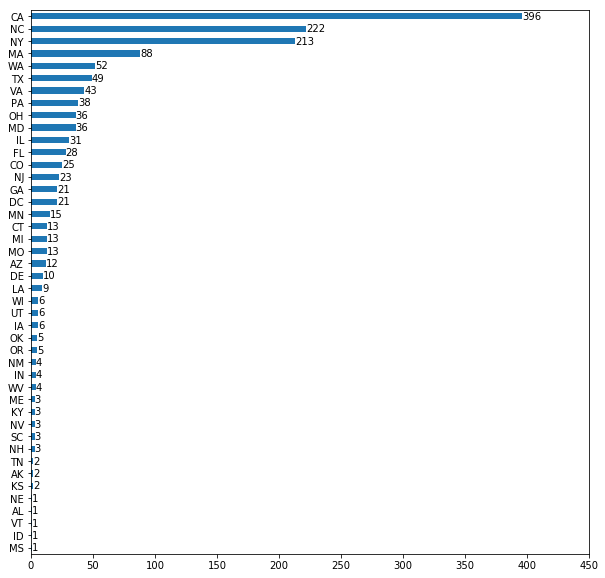

In [72]:
ax = jobs_dataframe['state'].value_counts(ascending=True).plot(kind="barh", figsize=(10,10), xlim=(0,450))
# add counts as annotations
# http://stackoverflow.com/questions/23591254/python-pandas-matplotlib-annotating-labels-above-bar-chart-columns
for p in ax.patches:
    ax.annotate("%d" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(0, 0), textcoords='offset points')

In [13]:
jobs_dataframe[jobs_dataframe['job_location'].str.contains("Pittsburgh")]

,company_link,company_name,job_link,job_location,job_summary,job_title
7,http://www.indeed.com/cmp/Marc-USA,MARC USA,http://www.indeed.com/rc/clk?jk=d884d5e0347faf...,"Pittsburgh, PA 15219 (Middle Hill area)",Providing a range of critical quantitative sup...,Market Research Analyst
278,None,kWantera,http://www.indeed.com/rc/clk?jk=7568b804290e9c...,"Pittsburgh, PA 15222 (Strip District area)",Past experience collaborating with data scient...,Data Engineer
682,http://www.indeed.com/cmp/Pnc-Bank,PNC Bank,http://www.indeed.com/rc/clk?jk=9762b3594410c0...,"Pittsburgh, PA",The preferred candidate will have experience w...,Quantitative Analytics & Model Development Ana...
876,http://www.indeed.com/cmp/Thermo-Fisher-Scient...,Thermo Fisher Scientific,http://www.indeed.com/rc/clk?jk=c2a8c0d8324b71...,"Pittsburgh, PA 15202",Recommend product categories where scientists ...,Product Conversion Specialist
921,None,DBD Staffing,http://www.indeed.com/company/DBD-Staffing/job...,"Pittsburgh, PA",Manage data analysis support for segment targe...,Statistical Marketing Analyst
932,None,DBD Staffing,http://www.indeed.com/company/DBD-Staffing/job...,"Pittsburgh, PA",Manage data analysis support for segment targe...,Statistical Marketing Analyst


### Analyzing Company Information

In [29]:
company_dataframe.head()

,compensation_benefits_rating,culture_rating,js_advancement_rating,management_rating,overall_rating,url,wl_balanace_rating
0,3.9,3.5,3.3,3.4,3.9,http://www.indeed.com/cmp/Population-Council,3.8
1,3.6,3.8,3.2,3.9,4.0,"http://www.indeed.com/cmp/Ensco,-Inc.",4.1
2,3.9,3.6,3.3,3.4,3.8,http://www.indeed.com/cmp/General-Dynamics-Inf...,3.7
3,3.2,3.8,2.9,3.4,3.5,http://www.indeed.com/cmp/Mintel,3.7
4,4.5,3.5,1.5,3.5,4.0,http://www.indeed.com/cmp/Spacecurve,4.5


In [35]:
company_dataframe.describe()

,compensation_benefits_rating,culture_rating,js_advancement_rating,management_rating,overall_rating,wl_balanace_rating
count,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000
mean,3.693147,3.657868,3.322081,3.406853,3.867005,3.757107
std,0.524687,0.531120,0.534313,0.542193,0.439729,0.529691
min,0.000000,0.000000,0.000000,0.000000,1.700000,0.000000
25%,3.400000,3.400000,3.000000,3.200000,3.700000,3.500000
50%,3.800000,3.700000,3.400000,3.400000,4.000000,3.800000
75%,4.000000,4.000000,3.600000,3.700000,4.200000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


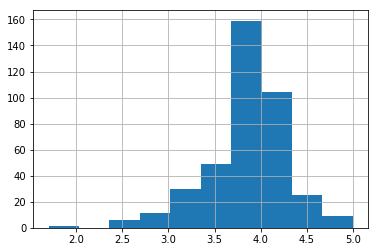

In [28]:
company_dataframe['overall_rating'].hist()

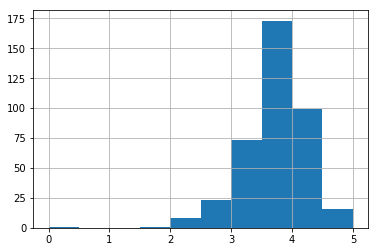

In [30]:
company_dataframe['culture_rating'].hist()

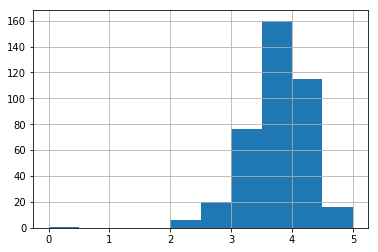

In [31]:
company_dataframe['compensation_benefits_rating'].hist()

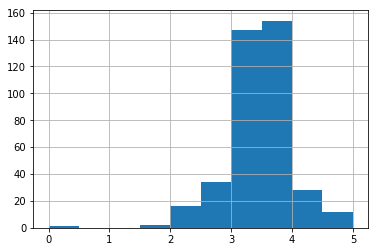

In [32]:
company_dataframe['management_rating'].hist()

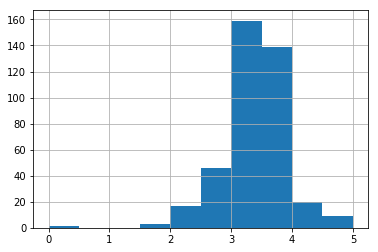

In [33]:
company_dataframe['js_advancement_rating'].hist()